In [1]:
import os
import sys
pwd = os.getcwd()
sys.path.append(os.path.join(pwd, '..', '..'))

from server.utils import load_config
from server import db
from sqlalchemy.orm import sessionmaker
import json
import matplotlib.pyplot as plt

conf_dir = os.path.abspath(os.path.join(pwd, '..', '..', 'config', 'base.yaml'))
config = load_config(conf_dir)

engine = db.sync_engine(config['postgres'])
Session = sessionmaker(bind=engine)
session = Session()

In [2]:
from sqlalchemy.orm.exc import NoResultFound
import sqlalchemy as sa
from server.trade.VolumeStrategy import VolumeStrategy
from server.trade.player import START_TIME, END_TIME

rate = 1
table_name = 'demo_order'
table = getattr(db, table_name)
all_orders_flag = 1
start_date_filter = START_TIME
end_date_filter = END_TIME

pair = VolumeStrategy.PAIR

cursor = session.query(table).filter(
    (table.c.extra[VolumeStrategy.ORDER_CLASS.FLAG_NAME].astext == '0')
    & (table.c.pair == pair)
    & (table.c.pub_date > start_date_filter)
    & (table.c.pub_date < end_date_filter)
).order_by(table.c.pub_date)

if all_orders_flag:
    all_orders = session.query(table).filter(
        (table.c.pair == pair)
        & (table.c.pub_date > start_date_filter)
        & (table.c.pub_date < end_date_filter)
    ).order_by(table.c.pub_date)

if rate:
    rate = session.query(db.history).filter(
        (db.history.c.pub_date > start_date_filter)
        & (db.history.c.pub_date < end_date_filter)
        & (db.history.c.pair == pair)
        & (sa.sql.func.random() < 0.007)
    ).order_by(db.history.c.pub_date)

In [3]:
def iter_tail(item, tail):
    next_steps = session.query(table).filter(
        ((table.c.extra['parent'].astext == str(item['id']))
        | (table.c.extra['merged'].astext == str(item['id']))
        ) 
        & (table.c.pub_date > start_date_filter)
        & (table.c.pub_date < end_date_filter)
    )
    if not next_steps.count():
        if len(tail) == 0:
            tail.append([item, item])
        return tail
    else: 
        for next_step in next_steps:
            next_step_item = as_dict(next_step)
            tail.append([item, next_step_item])
            tail = iter_tail(next_step_item, tail)
        return tail

In [4]:
order_dict = {
    'sell': [],
    'buy': []
}
if all_orders_flag:
    for order in all_orders:
        order_dict['sell' if order.is_sell else 'buy'].append({
            'date': order.pub_date,
            'price': order.price
        })
if rate:   
    rate_dict = {
        'date': [],
        'sell_price': [],
        'buy_price': []
    }
    for rate_info in rate:
        resp = json.loads(rate_info.resp)
        rate_dict['date'].append(rate_info.pub_date)
        rate_dict['buy_price'].append(resp['asks'][0][0])
        rate_dict['sell_price'].append(resp['bids'][0][0])
    print(len(rate_dict['date']))

1581


1


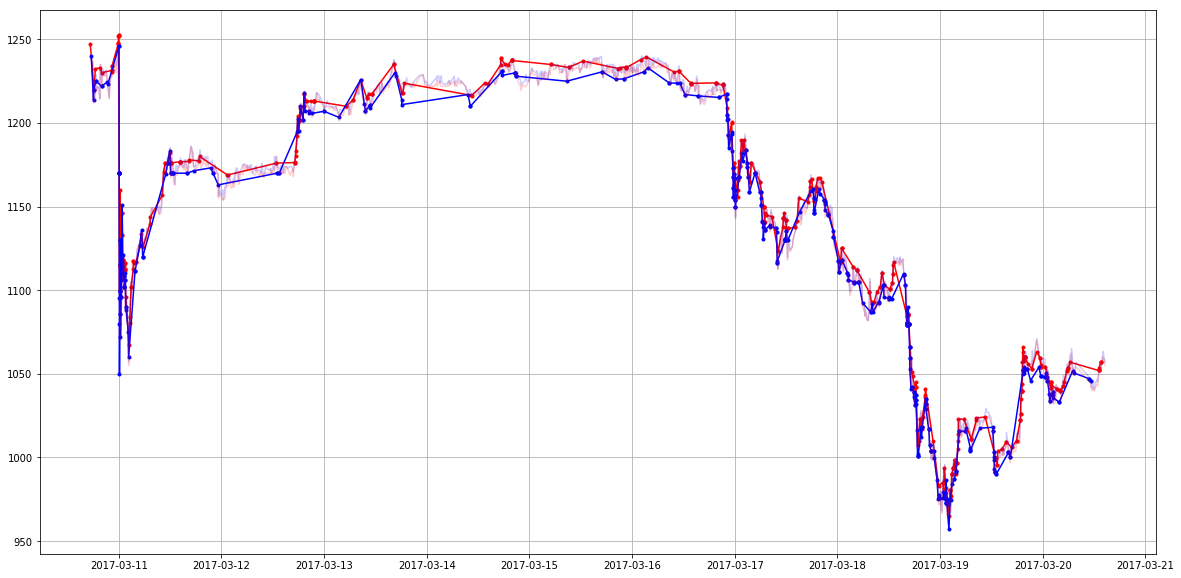

In [8]:
plt.cla()
plt.clf()
fig = plt.figure(figsize=(20,10))

ay = fig.add_subplot(1,1,1)
ay.grid(True)

for name, vals in order_dict.items():
    ay.plot(
        list(map(lambda i: i['date'], vals)), 
        list(map(lambda i: i['price'], vals)),
        color = 'red' if name == 'sell' else 'blue',
        marker= '.'
    )

if rate:    
    ay.plot(rate_dict['date'], rate_dict['buy_price'], alpha=0.2, color='blue')
    ay.plot(rate_dict['date'], rate_dict['sell_price'], alpha=0.2, color='red')
print(all_orders_flag)

fig